In [29]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np 
import csv

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from experiment_helpers.metrics import * 
from src.solvers import *
from src.syntetic import *




In [30]:

def plot_error_results(ax, results, method):
    """Plot the accuracy comparison for a specific method on a given axis."""
    ax.set_title(f'Accuracy Comparison - {method}')
    ax.set_ylabel(method)
    ax.set_xlabel('Test Size')
  
    independent = [experiment['test_size'] for experiment in results]
    graph_accuracy = [experiment['graph_accuracy'] for experiment in results]
    hyper_graph_accuracy = [experiment['hyper_graph_accuracy'] for experiment in results]

    ax.plot(independent, graph_accuracy, label='Standard Graph Accuracy', marker='o')
    ax.plot(independent, hyper_graph_accuracy, label='Hyper-graph Accuracy', marker='s')

    ax.legend()
    # ax.grid(True)

def plot_all_error_results(results_dict):
    """Plot the error comparison for all methods in a single row."""
    methods = list(results_dict.keys())
    num_methods = len(methods)
    
    fig, axs = plt.subplots(1, num_methods, figsize=(6 * num_methods, 6))

    for i, method in enumerate(methods):
        plot_error_results(axs[i], results_dict[method], method)
    
    plt.tight_layout()
    plt.show()

def measure_experiment(predicted_scores : dict[str:int], ground_truth_scores: dict[str:int], loss_measurement: str) -> float:

    if loss_measurement == 'rms':
        return calculate_rms(predicted_scores, ground_truth_scores)
    elif loss_measurement == 'rho':
        return calculate_rho(predicted_scores, ground_truth_scores)
    elif loss_measurement == 'tau':
        return calculate_tau(predicted_scores, ground_truth_scores)
    # elif loss_type == 'log_loss':
    #     return log_loss(predicted_scores)
    else:
        return 0 

def test_training_size(N,M,K1,K2, loss_measurement ='rms', repetitions = 5):

    all_results = []

    pi_values, data = generate_model_instance(N, M, K1, K2)


    for test_size in np.arange(0, 1.1, 0.1):

        hyper_graph_accuracy = []
        graph_accuracy = []

        for _ in range(repetitions):
           

            # take a percentile of total interactions
            training_subsize = int(len(data) * test_size)
            interactions = random.sample(data, k=training_subsize)

            # Create hypergraph
            bond_matrix = create_hypergraph_from_data(interactions)

            # Standard graph
            bin_data = binarize_data(interactions)
            bin_bond_matrix = create_hypergraph_from_data(bin_data)
            
            # predict ranks based on subset of games
            predicted_hyper_graph_scores , _ = synch_solve_equations(bond_matrix, 500, pi_values, 'newman', sens=1e-6)
            predicted_graph_scores, _ = synch_solve_equations(bin_bond_matrix, 500, pi_values, 'newman', sens=1e-6)
    
            # Measure accuracy for hypergraph and standard graph
            hyper_graph_accuracy.append( measure_experiment(predicted_hyper_graph_scores, pi_values, loss_measurement) )
            graph_accuracy.append( measure_experiment(predicted_graph_scores, pi_values, loss_measurement) )

        all_results.append({
            'loss_measurement': loss_measurement,
            'test_size': test_size,
            'graph_accuracy': np.mean(graph_accuracy),
            'hyper_graph_accuracy': np.mean(hyper_graph_accuracy)
        })

    return all_results


def run_all_metrics(M, N, K1, K2): 

    rms = test_training_size(N,M,K1,K2, loss_measurement ='rms')
    rho = test_training_size(N,M,K1,K2, loss_measurement = 'rho')
    tau = test_training_size(N,M,K1,K2, loss_measurement = 'tau')

    results_dict = {
        'rms': rms,
        'rho': rho,
        'tau': tau
    }

    plot_all_error_results(results_dict)
    


def save_results_to_csv(filename, results, experiment_label):
    fieldnames = ['experiment_label', 'test_size', 'graph_accuracy', 'hyper_graph_accuracy', 'loss_measurement']
    file_exists = os.path.isfile(filename)
    
    with open(filename, mode='a', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        if not file_exists:
            writer.writeheader()
        for result in results:
            result['experiment_label'] = experiment_label
            writer.writerow(result)
   

/home/jackyeung99/senior_thesis/higher_order_ranking/experiments/experiment_helpers/metrics.py:35: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_val = spearmanr(predicted_scores, true_scores)


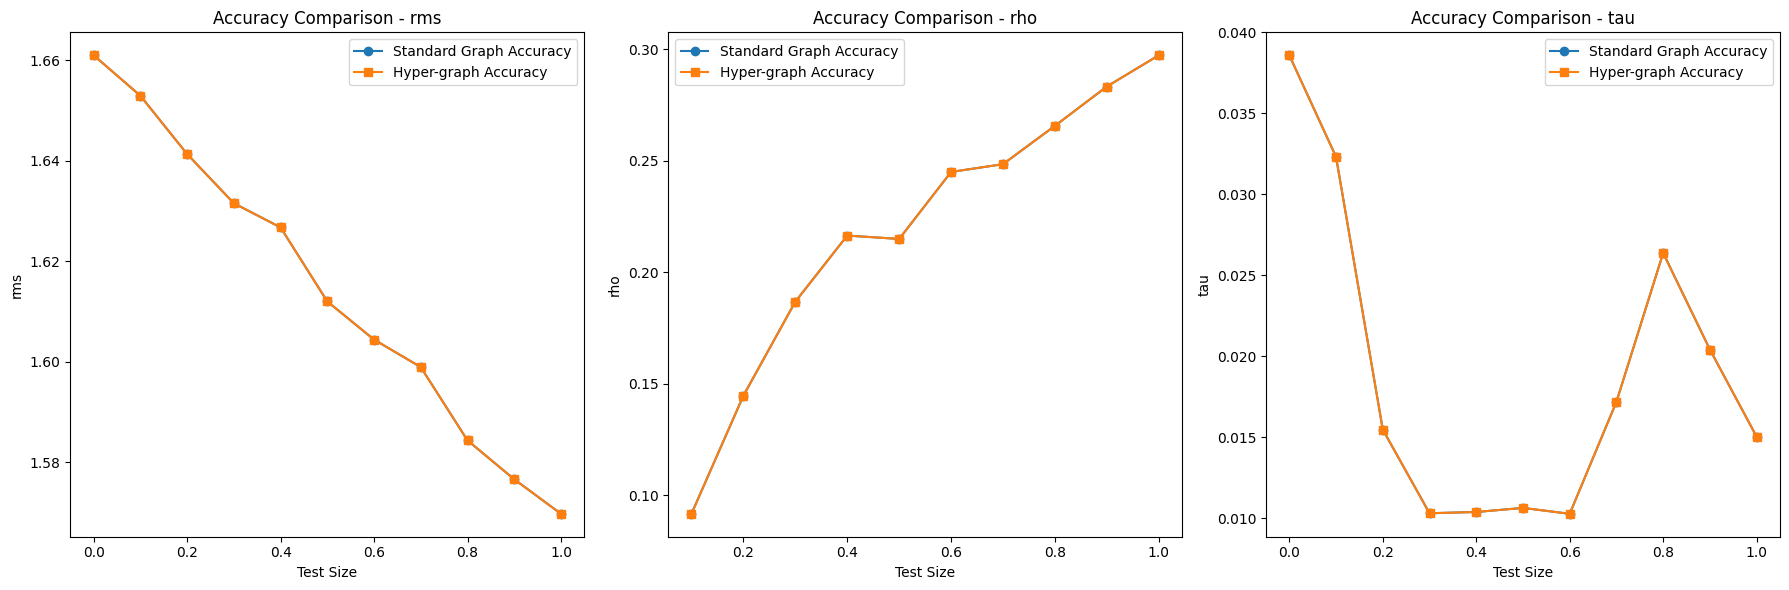

In [31]:
# Check dyadic hyperedges and standard graph produce the same results
run_all_metrics(250,750,2,2)


In [32]:
# Syntethic golf tournament example
run_all_metrics(150,150,2,3)


KeyboardInterrupt: 

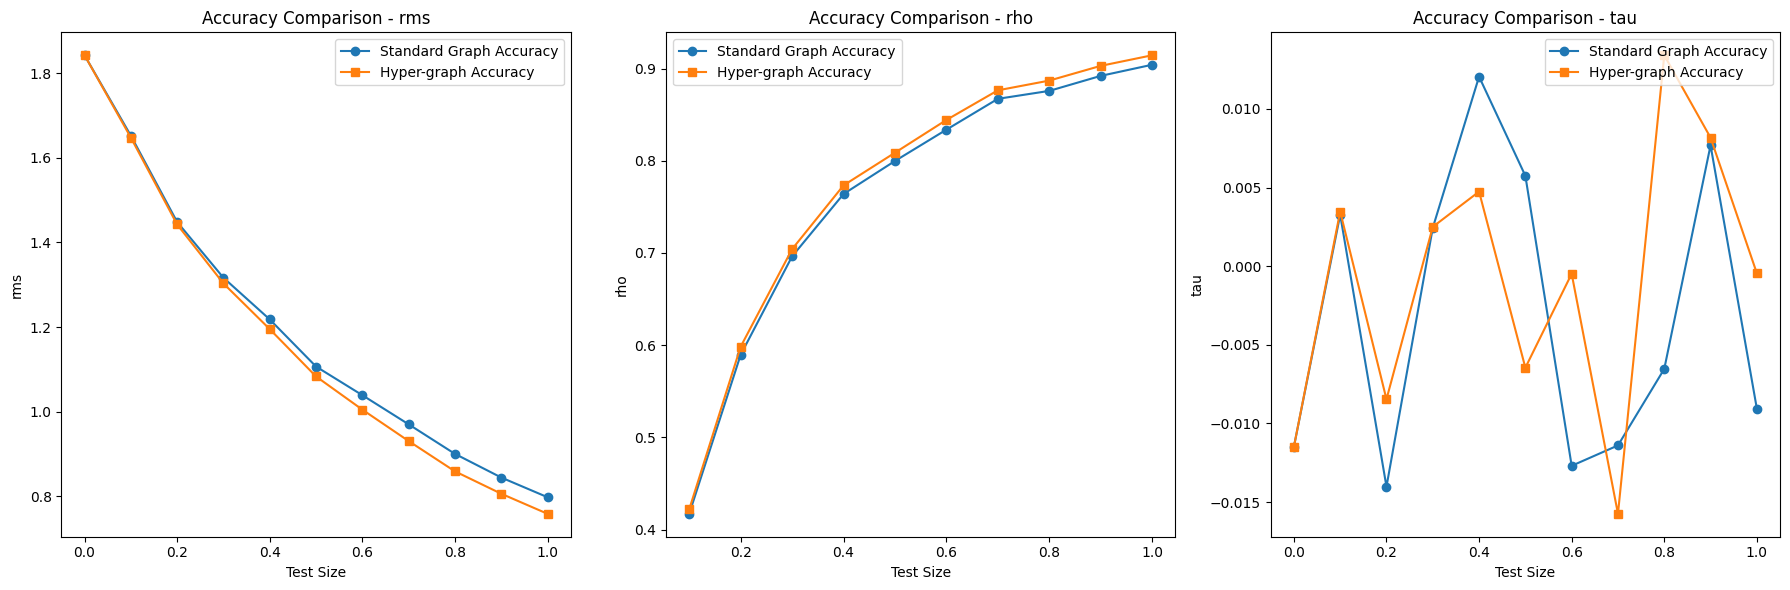

In [ ]:
# sample poker tournament
# stage one 
run_all_metrics(600,1200,9,10)

In [34]:




training_regime = [
     {'label': '1:.5', 'M': 250, 'N': 125, 'K1': 5, 'K2': 10, 'loss_measurement': 'rms'},
     {'label': '1:1', 'M': 250, 'N': 250, 'K1': 5, 'K2': 10, 'loss_measurement': 'rms'},
     {'label': '1:5','M': 250, 'N': 1250, 'K1': 5, 'K2': 10, 'loss_measurement': 'rms'},
     {'label': '1:10','M': 250, 'N': 2500, 'K1': 5, 'K2': 10, 'loss_measurement': 'rms'},

     {'label': '1:.5', 'M': 250, 'N': 125, 'K1': 5, 'K2': 10, 'loss_measurement': 'tau'},
     {'label': '1:1', 'M': 250, 'N': 250, 'K1': 5, 'K2': 10, 'loss_measurement': 'tau'},
     {'label': '1:5','M': 250, 'N': 1250, 'K1': 5, 'K2': 10, 'loss_measurement': 'tau'},
     {'label': '1:10','M': 250, 'N': 2500, 'K1': 5, 'K2': 10, 'loss_measurement': 'tau'},
     
     {'label': '1:.5', 'M': 250, 'N': 125, 'K1': 5, 'K2': 10, 'loss_measurement': 'rho'},
     {'label': '1:1', 'M': 250, 'N': 250, 'K1': 5, 'K2': 10, 'loss_measurement': 'rho'},
     {'label': '1:5','M': 250, 'N': 1250, 'K1': 5, 'K2': 10, 'loss_measurement': 'rho'},
     {'label': '1:10','M': 250, 'N': 2500, 'K1': 5, 'K2': 10, 'loss_measurement': 'rho'}
]

filename = 'experiment_results.csv'

for experiment in training_regime: 
    results = test_training_size(experiment['M'], experiment['N'], experiment['K1'], experiment['K2'], experiment['loss_measurement'])
    save_results_to_csv(filename, results, experiment['label'])

KeyboardInterrupt: 